In [1]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from mobile_sam import SamAutomaticMaskGenerator
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np


/Users/noahmac/Desktop/uni/kandidat/9_semester/ATIA/project/mobileSam_adapter/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/noahmac/Desktop/uni/kandidat/9_semester/ATIA/project/mobileSam_adapter/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/noahmac/Desktop/uni/kandidat/9_semester/ATIA/project/mobileSam_adapter/.venv/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureW

In [16]:
model_type = "vit_t"
sam_checkpoint = "./MobileSam/weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()

# predictor = SamPredictor(mobile_sam)
# predictor.set_image(<your_image>)
# masks, _, _ = predictor.predict(<input_prompts>)

LR SCALES: [0.08589934592000005, 0.10737418240000006, 0.13421772800000006, 0.1677721600000001, 0.20971520000000007, 0.2621440000000001, 0.3276800000000001, 0.4096000000000001, 0.5120000000000001, 0.6400000000000001, 0.8, 1.0]


Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

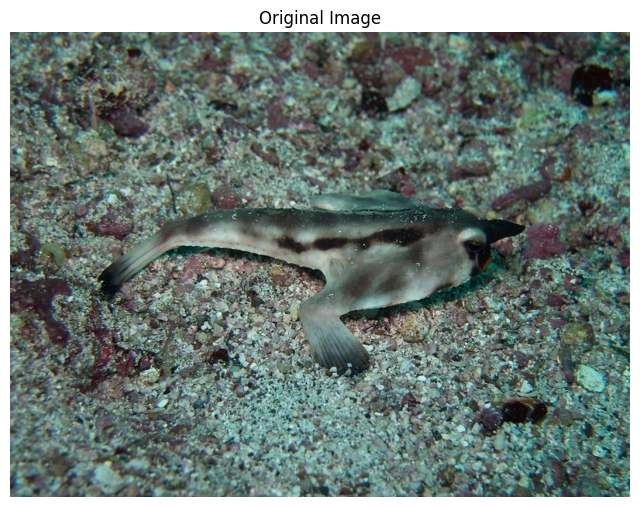

In [17]:
img_path = "./data/COD10K-v3/Train/Image/COD10K-CAM-1-Aquatic-1-BatFish-1.jpg"

image_bgr = cv2.imread(img_path)

# 2. Convert BGR -> RGB for SAM
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 3. Display original image
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Original Image")
plt.show()


In [18]:
mask_generator = SamAutomaticMaskGenerator(mobile_sam)
masks = mask_generator.generate(image_rgb)

In [23]:
len(masks)

79

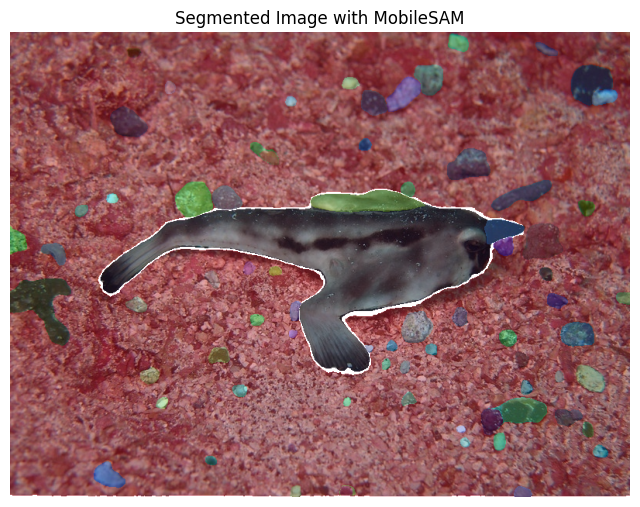

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0],
                   sorted_anns[0]['segmentation'].shape[1], 4))
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
show_anns(masks)
plt.axis("off")
plt.title("Segmented Image with MobileSAM")
plt.show()

In [24]:
# Load ground truth mask (white=object, black=background)
gt_mask = cv2.imread("./data/COD10K-v3/Train/GT_Object/COD10K-CAM-1-Aquatic-1-BatFish-1.png", cv2.IMREAD_GRAYSCALE)
gt_mask = (gt_mask > 127).astype(np.uint8)  # binarize (0 or 1)

def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0:
        return 0.0
    return intersection / union

In [25]:
best_mask = None
best_iou = -1

for m in masks:
    pred_mask = m['segmentation']
    iou = compute_iou(pred_mask, gt_mask)
    if iou > best_iou:
        best_iou = iou
        best_mask = pred_mask

print("Best IoU:", best_iou)

Best IoU: 0.9622425160735493


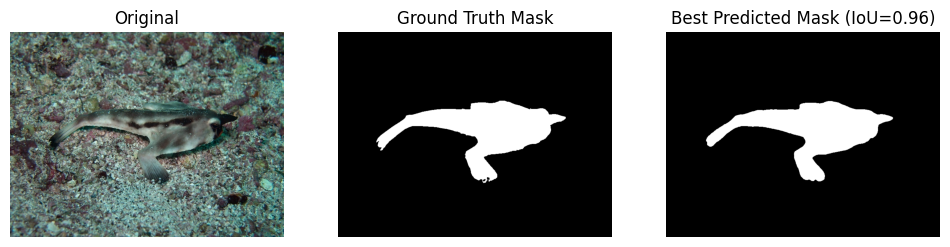

In [26]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(best_mask, cmap="gray")
plt.title(f"Best Predicted Mask (IoU={best_iou:.2f})")
plt.axis("off")

plt.show()